# Soft Threshold

In [191]:
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd

def add_awgn_noise(image, std_dev):
    noise = np.random.normal(0, std_dev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def denoise_image(noisy_image, wavelet, threshold):
    coeffs = pywt.dwt2(noisy_image, wavelet, mode='symmetric')
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    reconstructed_image = pywt.idwt2(coeffs, wavelet, mode='symmetric')
    reconstructed_image = reconstructed_image[:noisy_image.shape[0], :noisy_image.shape[1]]
    print(reconstructed_image.shape)
    return np.uint8(reconstructed_image)

def calculate_metrics(original_image, noisy_image, reconstructed_image):
    mse = np.mean((original_image - reconstructed_image) ** 2)
    psnr = cv2.PSNR(original_image, reconstructed_image)
    ssim_val = ssim(original_image, reconstructed_image)
    entropy = -np.sum(cv2.calcHist([original_image], [0], None, [256], [0, 256]) * np.log2(1e-10 + cv2.calcHist([original_image], [0], None, [256], [0, 256])))
    std_dev = np.std(original_image)
    variance = np.var(original_image)
    return mse, psnr, ssim_val, entropy, std_dev, variance

def calculate_snr(original_image, noisy_image, reconstructed_image):
    variance_signal = np.var(original_image)
    noise_original = noisy_image - original_image
    noise_reconstructed = reconstructed_image - original_image
    variance_noise_original = np.var(noise_original)
    variance_noise_reconstructed = np.var(noise_reconstructed)
    snr_original = 10 * np.log10(variance_signal / variance_noise_original)
    snr_original_reconstructed = 10 * np.log10(variance_signal / variance_noise_reconstructed)
    return snr_original, snr_original_reconstructed

def evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range):
    results = []
    temp = []
    results_dataframe = []
    result_std_snr_avg = [] 
    for std_dev in std_dev_range:
        noisy_image = add_awgn_noise(original_image, std_dev)
        for threshold in threshold_range:
            reconstructed_image = denoise_image(noisy_image, wavelet, threshold)
            metrics = calculate_metrics(original_image, noisy_image, reconstructed_image)
            snr_original, snr_original_reconstructed = calculate_snr(original_image, noisy_image, reconstructed_image)
            results.append({'Std_Dev': std_dev, 'Threshold': threshold, 'MSE': metrics[0], 'PSNR': metrics[1], 'SSIM': metrics[2], 'Entropy': metrics[3], 'Standard_Deviation': metrics[4], 'Variance': metrics[5], 'SNR_Original': snr_original, 'SNR_Reconstructed': snr_original_reconstructed})
            temp.append({'Std_Dev': std_dev, 'Threshold': threshold, 'MSE': metrics[0], 'PSNR': metrics[1], 'SSIM': metrics[2], 'Entropy': metrics[3], 'Standard_Deviation': metrics[4], 'Variance': metrics[5], 'SNR_Original': snr_original, 'SNR_Reconstructed': snr_original_reconstructed})
        snr_original_avg = np.mean(snr_original)
        snr_original_reconstructed_avg = np.mean(snr_original_reconstructed)
        result_std_snr_avg.append({'Std_Dev': std_dev , 'AvgSNR_Original': snr_original_avg, 'AvgSNR_Reconstructed': snr_original_reconstructed_avg})
        results_dataframe.append(pd.DataFrame(temp))
        temp = []
    return pd.DataFrame(results) , results_dataframe , pd.DataFrame(result_std_snr_avg)

def plot_snr_vs_threshold(df, std_dev):
    df_std_dev = df[std_dev]
    plt.figure(figsize=(10, 6)) 
    plt.plot(df_std_dev['Threshold'], df_std_dev['SNR_Reconstructed'], marker='o',markersize=2)
    plt.xlabel('Threshold')
    plt.ylabel('SNR (Reconstructed Image)')
    plt.title(f'SNR vs Threshold for Std Dev {df_std_dev.at[0, "Std_Dev"]}')
    plt.grid(True)
    plt.show()

def plot_snr_vs_std_dev(df):
    plt.figure(figsize=(10, 6)) 
    plt.plot(df['Std_Dev'], df['SNR_Original'], marker='o')
    plt.xlabel('AWGN Std Dev')
    plt.ylabel('SNR (Original Noised Image)')
    plt.title('SNR vs AWGN Std Dev')
    plt.grid(True)
    plt.show()

# Load the original grayscale image
# original_image = cv2.imread('APC.tiff', cv2.IMREAD_GRAYSCALE)

# # Define parameters
# wavelet = 'haar'
# std_dev = [15,25,50]
# threshold_range = np.arange(1, 400, 2)
# std_dev_range = np.array(std_dev)

# Evaluate different std_dev and threshold values
#results_df , list_df ,snr_std_avg= evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range)



In [192]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt



def plot_snr_vs_threshold(df):
    plt.figure(figsize=(15, 6)) 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    peak_markers = ['x', '+', '^', 's', 'o']  # Define markers for peaks
    
    for i in range(0, 3):
        df_std_dev = df[i]
        plt.plot(df_std_dev['Threshold'], df_std_dev['SNR_Reconstructed'], marker='o', markersize=1)
        plt.plot(df_std_dev['Threshold'], df_std_dev['SNR_Reconstructed'], marker='o', markersize=3, label=f'Std Dev {df_std_dev.at[i, "Std_Dev"]}', color=colors[i])
        
        # Find peaks in SNR values
        peaks, _ = find_peaks(df_std_dev['SNR_Reconstructed'])
        
        # Mark peaks on the plot
        for peak in peaks:
            threshold_value = df_std_dev['Threshold'].iloc[peak]
            plt.plot(df_std_dev['Threshold'].iloc[peak], df_std_dev['SNR_Reconstructed'].iloc[peak], marker=peak_markers[i], markersize=10, linestyle='', color=colors[i], label=f'Peak (Threshold: {threshold_value}, Std Dev {df_std_dev.at[i, "Std_Dev"]})')
    
    plt.xlabel('Threshold')
    plt.ylabel('SNR (Reconstructed Image)')
    plt.title('SNR vs Threshold for Std Dev')
    plt.grid(True)
    plt.legend()  # Add legend
    plt.show()

def plot_snr_vs_std_dev(df):
    plt.figure(figsize=(15, 6)) 
    plt.plot(df['Std_Dev'], df['SNR_Original'], marker='o')
    plt.xlabel('AWGN Std Dev')
    plt.ylabel('SNR (Original Noised Image)')
    plt.title('SNR vs AWGN Std Dev')
    plt.grid(True)
    plt.show()

def plot_ssim_vs_snr(df):
    plt.figure(figsize=(15, 6)) 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i in range(0,3):
        df_std_dev = df[i]
        plt.plot(1000*df_std_dev['SSIM'], 1000*df_std_dev['Threshold'], marker='o', markersize=3, label=f'Std Dev {df_std_dev.at[i, "Std_Dev"]}', color=colors[i])
    plt.xlabel('SSIM')
    plt.ylabel('SNR_Reconstructed')
    plt.title(f'SSIM vs SNR')
    plt.grid(True)
    plt.legend()  # Add legend
    plt.xticks(fontsize=10)  # You can adjust the font size as needed
    plt.yticks(fontsize=10)  # You can adjust the font size as needed
    #plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.10f'))  # 3 decimal places
    #plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.10f'))  # 3 decimal places

    plt.show()





In [211]:
import os
import cv2

# Folder path
folder_path = '/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12'

# Extension to filter
extension = '.png'  # Change this to the desired extension

# List to store file paths with the specified extension
files_with_extension = []

wavelet = 'haar'
std_dev = [15,25,50]
threshold_range = np.arange(1, 400, 2)
std_dev_range = np.array(std_dev)

# Evaluate different std_dev and threshold values



# Iterate over files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(extension):
        file_path = os.path.join(folder_path, file_name)
        files_with_extension.append(file_path)

all_results_df = []
all_list_df = []
all_snr_std_avg = []

# Loop through filtered files and process them
for file_path in files_with_extension:
    original_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    print("The image file under process")
    print()
    if original_image is None:
        print(f"Error: Unable to read image {file_path}")
    else:
        # Process the image and store the returned DataFrames
        print("The image file under process")
        print(file_path)
        results_df, list_df, snr_std_avg = evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range)
        
        # Append the DataFrames to the lists
        all_results_df.append(results_df)
        all_list_df.append(list_df)
        all_snr_std_avg.append(snr_std_avg)

print(len(all_results_df))      
print(len(all_list_df))      
print(len(all_snr_std_avg))      



The image file under process

The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/01.png
The image file under process

The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/03.png
The image file under process

The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/02.png
The image file under process

The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/06.png
The image file under process

The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/12.png
The image file under process

The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/07.png
The image file under process

The image file under process

In [212]:
# Perform cell-wise addition for all_results_df
combined_results_df_soft = pd.DataFrame()
for df in all_results_df:
    combined_results_df_soft = combined_results_df_soft.add(df, fill_value=0)
combined_results_df_soft = combined_results_df_soft/len(all_results_df)   
# # Perform cell-wise addition for all_list_df
combined_list_df = []
# for i in range(len(all_list_df[0])):
#     combined_list_df.append(all_list_df[0][i].copy())  # Make a copy of the first DataFrame
#     for j in range(1, len(all_list_df)):
#         combined_list_df[i] += all_list_df[j][i]
temp1 = pd.DataFrame()
temp2 = pd.DataFrame()
temp3 = pd.DataFrame()

combined_list_df_soft = []
for i in all_list_df:
    temp1 = temp1.add(i[0] , fill_value = 0)
    temp2 = temp2.add(i[1] , fill_value = 0)
    temp3 = temp3.add(i[2] , fill_value = 0)
temp1 = temp1/len(all_results_df)
temp2 = temp2/len(all_results_df)
temp3 = temp3/len(all_results_df)
combined_list_df_soft.append(temp1)
combined_list_df_soft.append(temp2)
combined_list_df_soft.append(temp3)       

    
# Perform cell-wise addition for all_snr_std_avg
combined_snr_std_avg_soft = pd.DataFrame()
for df in all_snr_std_avg:
    combined_snr_std_avg_soft = combined_snr_std_avg_soft.add(df, fill_value=0)
combined_snr_std_avg_soft = combined_snr_std_avg_soft/len(all_results_df)
# Now combined_results_df, combined_list_df, and combined_snr_std_avg contain the cell-wise

In [221]:
averages1_12 = combined_list_df_soft[0].mean()
averages2_12 = combined_list_df_soft[1].mean()
averages3_12 = combined_list_df_soft[2].mean()

In [222]:
averages1_12

Std_Dev               1.500000e+01
Threshold             2.000000e+02
MSE                   1.073864e+02
PSNR                  9.513879e+00
SSIM                  1.756463e-01
Entropy              -1.503427e+06
Standard_Deviation    5.252398e+01
Variance              2.807706e+03
SNR_Original         -2.447415e+00
SNR_Reconstructed    -1.461986e+00
dtype: float64

In [223]:
averages2_12

Std_Dev               2.500000e+01
Threshold             2.000000e+02
MSE                   1.099242e+02
PSNR                  9.293203e+00
SSIM                  1.866331e-01
Entropy              -1.503427e+06
Standard_Deviation    5.252398e+01
Variance              2.807706e+03
SNR_Original         -2.097210e+00
SNR_Reconstructed    -9.104029e-01
dtype: float64

In [224]:
averages3_12

Std_Dev               5.000000e+01
Threshold             2.000000e+02
MSE                   1.104850e+02
PSNR                  8.937089e+00
SSIM                  2.105509e-01
Entropy              -1.503427e+06
Standard_Deviation    5.252398e+01
Variance              2.807706e+03
SNR_Original         -1.198395e+00
SNR_Reconstructed     1.630196e-01
dtype: float64

In [214]:

# Folder path
folder_path_1 = '/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set68'

# Extension to filter
extension = '.png'  # Change this to the desired extension

files_with_extension = []

# Iterate over files in the folder
for file_name in os.listdir(folder_path_1):
    if file_name.endswith(extension):
        print(file_name)
        file_path = os.path.join(folder_path_1, file_name)
        files_with_extension.append(file_path)
all_results_df = []
all_list_df = []
all_snr_std_avg = []

# Loop through filtered files and process them
for file_path in files_with_extension:
    original_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    print("The image file under process")
    print()
    if original_image is None:
        print(f"Error: Unable to read image {file_path}")
    else:
        # Process the image and store the returned DataFrames
        print("The image file under process")
        print(file_path)
        results_df, list_df, snr_std_avg = evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range)
        
        # Append the DataFrames to the lists
        all_results_df.append(results_df)
        all_list_df.append(list_df)
        all_snr_std_avg.append(snr_std_avg)
print(len(all_results_df))      
print(len(all_list_df))      
print(len(all_snr_std_avg))      

test041.png
test055.png
test054.png
test040.png
test068.png
test056.png
test042.png
test043.png
test057.png
test053.png
test047.png
test046.png
test052.png
test044.png
test050.png
test051.png
test045.png
test022.png
test036.png
test037.png
test023.png
test009.png
test035.png
test021.png
test020.png
test034.png
test008.png
test030.png
test024.png
test018.png
test019.png
test025.png
test031.png
test027.png
test033.png
test032.png
test026.png
test003.png
test017.png
test016.png
test002.png
test028.png
test014.png
test001.png
test015.png
test029.png
test011.png
test005.png
test039.png
test038.png
test004.png
test010.png
test006.png
test012.png
test013.png
test007.png
test048.png
test060.png
test061.png
test049.png
test063.png
test062.png
test066.png
test067.png
test065.png
test059.png
test058.png
test064.png
The image file under process

The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set68/test041.png
The image file under p

In [215]:
# Perform cell-wise addition for all_results_df
combined_results_df_soft_68 = pd.DataFrame()
for df in all_results_df:
    combined_results_df_soft_68 = combined_results_df_soft_68.add(df, fill_value=0)
combined_results_df_soft_68 = combined_results_df_soft_68/len(all_results_df)    
# # Perform cell-wise addition for all_list_df
combined_list_df_soft_68 = []
# for i in range(len(all_list_df[0])):
#     combined_list_df.append(all_list_df[0][i].copy())  # Make a copy of the first DataFrame
#     for j in range(1, len(all_list_df)):
#         combined_list_df[i] += all_list_df[j][i]
temp1 = pd.DataFrame()
temp2 = pd.DataFrame()
temp3 = pd.DataFrame()

combined_list_df_soft_68 = []
for i in all_list_df:
    temp1 = temp1.add(i[0] , fill_value = 0)
    temp2 = temp2.add(i[1] , fill_value = 0)
    temp3 = temp3.add(i[2] , fill_value = 0)
temp1 = temp1/len(all_results_df)
temp2 = temp2/len(all_results_df)
temp3 = temp3/len(all_results_df)
combined_list_df_soft_68.append(temp1)
combined_list_df_soft_68.append(temp2)
combined_list_df_soft_68.append(temp3)       

    
# Perform cell-wise addition for all_snr_std_avg
combined_snr_std_avg_soft_68 = pd.DataFrame()
for df in all_snr_std_avg:
    combined_snr_std_avg_soft_68 = combined_snr_std_avg_soft_68.add(df, fill_value=0)
combined_snr_std_avg_soft_68 = combined_snr_std_avg_soft_68/len(all_results_df)
# Now combined_results_df, combined_list_df, and combined_snr_std_avg contain the cell-wise

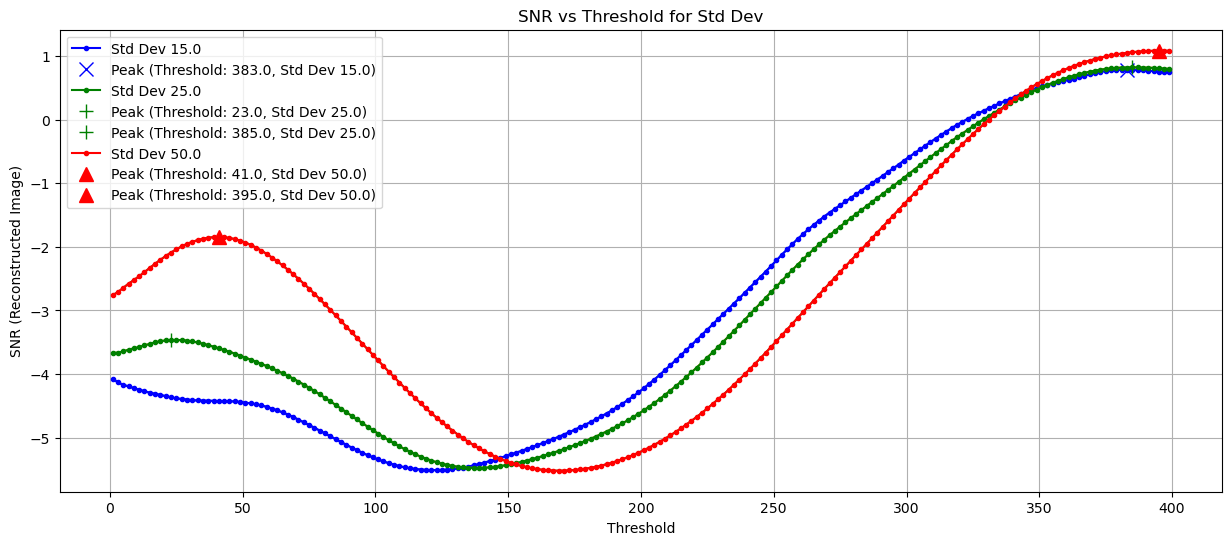

In [200]:
# Plot SNR vs Threshold for a particular std_dev
plot_snr_vs_threshold(combined_list_df_soft)

# # Plot SNR vs AWGN Std Dev
# plot_snr_vs_std_dev(combined_results_df)
# plot_ssim_vs_snr(combined_list_df)

In [217]:
averages1_68 = combined_list_df_soft_68[0].mean()
averages2_68 = combined_list_df_soft_68[1].mean()
averages3_68 = combined_list_df_soft_68[2].mean()

In [225]:
averages1_68

Std_Dev               1.500000e+01
Threshold             2.000000e+02
MSE                   1.023051e+02
PSNR                  8.683376e+00
SSIM                  1.615239e-01
Entropy              -1.554961e+06
Standard_Deviation    5.236259e+01
Variance              3.009907e+03
SNR_Original         -3.736558e+00
SNR_Reconstructed    -2.256154e+00
dtype: float64

In [226]:
averages2_68

Std_Dev               2.500000e+01
Threshold             2.000000e+02
MSE                   1.046046e+02
PSNR                  8.498188e+00
SSIM                  1.676144e-01
Entropy              -1.554961e+06
Standard_Deviation    5.236259e+01
Variance              3.009907e+03
SNR_Original         -3.409079e+00
SNR_Reconstructed    -1.775339e+00
dtype: float64

In [227]:
averages3_68

Std_Dev               5.000000e+01
Threshold             2.000000e+02
MSE                   1.050219e+02
PSNR                  8.202580e+00
SSIM                  1.814847e-01
Entropy              -1.554961e+06
Standard_Deviation    5.236259e+01
Variance              3.009907e+03
SNR_Original         -2.552632e+00
SNR_Reconstructed    -8.160388e-01
dtype: float64

# Hard threshold

In [228]:
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd

def add_awgn_noise(image, std_dev):
    noise = np.random.normal(0, std_dev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def denoise_image(noisy_image, wavelet, threshold):
    coeffs = pywt.dwt2(noisy_image, wavelet, mode='symmetric')
    coeffs = [pywt.threshold(c, threshold, mode='hard') for c in coeffs]
    reconstructed_image = pywt.idwt2(coeffs, wavelet, mode='symmetric')
    reconstructed_image = reconstructed_image[:noisy_image.shape[0], :noisy_image.shape[1]]
    return np.uint8(reconstructed_image)

def calculate_metrics(original_image, noisy_image, reconstructed_image):
    mse = np.mean((original_image - reconstructed_image) ** 2)
    psnr = cv2.PSNR(original_image, reconstructed_image)
    ssim_val = ssim(original_image, reconstructed_image)
    entropy = -np.sum(cv2.calcHist([original_image], [0], None, [256], [0, 256]) * np.log2(1e-10 + cv2.calcHist([original_image], [0], None, [256], [0, 256])))
    std_dev = np.std(original_image)
    variance = np.var(original_image)
    return mse, psnr, ssim_val, entropy, std_dev, variance

def calculate_snr(original_image, noisy_image, reconstructed_image):
    variance_signal = np.var(original_image)
    noise_original = noisy_image - original_image
    noise_reconstructed = reconstructed_image - original_image
    variance_noise_original = np.var(noise_original)
    variance_noise_reconstructed = np.var(noise_reconstructed)
    snr_original = 10 * np.log10(variance_signal / variance_noise_original)
    snr_original_reconstructed = 10 * np.log10(variance_signal / variance_noise_reconstructed)
    return snr_original, snr_original_reconstructed

def evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range):
    results = []
    temp = []
    results_dataframe = []
    result_std_snr_avg = [] 
    for std_dev in std_dev_range:
        noisy_image = add_awgn_noise(original_image, std_dev)
        for threshold in threshold_range:
            reconstructed_image = denoise_image(noisy_image, wavelet, threshold)
            metrics = calculate_metrics(original_image, noisy_image, reconstructed_image)
            snr_original, snr_original_reconstructed = calculate_snr(original_image, noisy_image, reconstructed_image)
            results.append({'Std_Dev': std_dev, 'Threshold': threshold, 'MSE': metrics[0], 'PSNR': metrics[1], 'SSIM': metrics[2], 'Entropy': metrics[3], 'Standard_Deviation': metrics[4], 'Variance': metrics[5], 'SNR_Original': snr_original, 'SNR_Reconstructed': snr_original_reconstructed})
            temp.append({'Std_Dev': std_dev, 'Threshold': threshold, 'MSE': metrics[0], 'PSNR': metrics[1], 'SSIM': metrics[2], 'Entropy': metrics[3], 'Standard_Deviation': metrics[4], 'Variance': metrics[5], 'SNR_Original': snr_original, 'SNR_Reconstructed': snr_original_reconstructed})
        snr_original_avg = np.mean(snr_original)
        snr_original_reconstructed_avg = np.mean(snr_original_reconstructed)
        result_std_snr_avg.append({'Std_Dev': std_dev , 'AvgSNR_Original': snr_original_avg, 'AvgSNR_Reconstructed': snr_original_reconstructed_avg})
        results_dataframe.append(pd.DataFrame(temp))
        temp = []
    return pd.DataFrame(results) , results_dataframe , pd.DataFrame(result_std_snr_avg)

# def plot_snr_vs_threshold(df, std_dev):
#     df_std_dev = df[std_dev]
#     plt.figure(figsize=(10, 6)) 
#     plt.plot(df_std_dev['Threshold'], df_std_dev['SNR_Reconstructed'], marker='o',markersize=2)
#     plt.xlabel('Threshold')
#     plt.ylabel('SNR (Reconstructed Image)')
#     plt.title(f'SNR vs Threshold for Std Dev {df_std_dev.at[0, "Std_Dev"]}')
#     plt.grid(True)
#     plt.show()

# def plot_snr_vs_std_dev(df):
#     plt.figure(figsize=(10, 6)) 
#     plt.plot(df['Std_Dev'], df['SNR_Original'], marker='o')
#     plt.xlabel('AWGN Std Dev')
#     plt.ylabel('SNR (Original Noised Image)')
#     plt.title('SNR vs AWGN Std Dev')
#     plt.grid(True)
#     plt.show()

# Load the original grayscale image
#original_image = cv2.imread('APC.tiff', cv2.IMREAD_GRAYSCALE)

# Define parameters
# wavelet = 'haar'
# std_dev = [15,25,50]
# threshold_range = np.arange(1, 400, 2)
# std_dev_range = np.array(std_dev)

# Evaluate different std_dev and threshold values
#results_df , list_df ,snr_std_avg= evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range)



In [229]:
import os
import cv2

# Folder path
folder_path = '/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12'

# Extension to filter
extension = '.png'  # Change this to the desired extension

# List to store file paths with the specified extension
files_with_extension = []

wavelet = 'haar'
std_dev = [15,25,50]
threshold_range = np.arange(1, 400, 2)
std_dev_range = np.array(std_dev)

# Evaluate different std_dev and threshold values



# Iterate over files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(extension):
        file_path = os.path.join(folder_path, file_name)
        files_with_extension.append(file_path)

all_results_df = []
all_list_df = []
all_snr_std_avg = []

# Loop through filtered files and process them
for file_path in files_with_extension:
    original_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Error: Unable to read image {file_path}")
        
    else:
        # Process the image and store the returned DataFrames
        results_df, list_df, snr_std_avg = evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range)
        print("The image file under process")
        print(file_path)
        # Append the DataFrames to the lists
        all_results_df.append(results_df)
        all_list_df.append(list_df)
        all_snr_std_avg.append(snr_std_avg)

        



The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/01.png
The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/03.png
The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/02.png
The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/06.png
The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/12.png
The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/07.png
The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set12/11.png
The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/da

In [230]:
# Perform cell-wise addition for all_results_df
combined_results_df = pd.DataFrame()
for df in all_results_df:
    combined_results_df = combined_results_df.add(df, fill_value=0)
combined_results_df = combined_results_df/len(all_results_df)
# # Perform cell-wise addition for all_list_df
combined_list_df = []
# for i in range(len(all_list_df[0])):
#     combined_list_df.append(all_list_df[0][i].copy())  # Make a copy of the first DataFrame
#     for j in range(1, len(all_list_df)):
#         combined_list_df[i] += all_list_df[j][i]
temp1 = pd.DataFrame()
temp2 = pd.DataFrame()
temp3 = pd.DataFrame()

combined_list_df = []
for i in all_list_df:
    temp1 = temp1.add(i[0] , fill_value = 0)
    temp2 = temp2.add(i[1] , fill_value = 0)
    temp3 = temp3.add(i[2] , fill_value = 0)
temp1 = temp1/len(all_results_df)
temp2 = temp2/len(all_results_df)
temp3 = temp3/len(all_results_df)
combined_list_df.append(temp1)
combined_list_df.append(temp2)
combined_list_df.append(temp3)       

    
# Perform cell-wise addition for all_snr_std_avg
combined_snr_std_avg = pd.DataFrame()
for df in all_snr_std_avg:
    combined_snr_std_avg = combined_snr_std_avg.add(df, fill_value=0)
combined_snr_std_avg = combined_snr_std_avg/len(all_results_df)
# Now combined_results_df, combined_list_df, and combined_snr_std_avg contain the cell-wise

In [235]:
averages1 = combined_list_df[0].mean()
averages2 = combined_list_df[1].mean()
averages3 = combined_list_df[2].mean()

In [236]:
averages1

Std_Dev               1.500000e+01
Threshold             2.000000e+02
MSE                   1.074557e+02
PSNR                  9.513536e+00
SSIM                  1.755200e-01
Entropy              -1.503427e+06
Standard_Deviation    5.252398e+01
Variance              2.807706e+03
SNR_Original         -2.448591e+00
SNR_Reconstructed    -1.462189e+00
dtype: float64

In [237]:
averages2

Std_Dev               2.500000e+01
Threshold             2.000000e+02
MSE                   1.099798e+02
PSNR                  9.301408e+00
SSIM                  1.874888e-01
Entropy              -1.503427e+06
Standard_Deviation    5.252398e+01
Variance              2.807706e+03
SNR_Original         -2.094854e+00
SNR_Reconstructed    -9.096945e-01
dtype: float64

In [238]:
averages3

Std_Dev               5.000000e+01
Threshold             2.000000e+02
MSE                   1.104639e+02
PSNR                  8.928243e+00
SSIM                  2.100377e-01
Entropy              -1.503427e+06
Standard_Deviation    5.252398e+01
Variance              2.807706e+03
SNR_Original         -1.192690e+00
SNR_Reconstructed     1.621324e-01
dtype: float64

In [232]:
# Folder path
folder_path_1 = '/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set68'

# Extension to filter
extension = '.png'  # Change this to the desired extension

files_with_extension = []

# Iterate over files in the folder
for file_name in os.listdir(folder_path_1):
    if file_name.endswith(extension):
        print(file_name)
        file_path = os.path.join(folder_path_1, file_name)
        files_with_extension.append(file_path)
all_results_df = []
all_list_df = []
all_snr_std_avg = []



# Loop through filtered files and process them
for file_path in files_with_extension:
    original_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    print("The image file under process")
    print()
    if original_image is None:
        print(f"Error: Unable to read image {file_path}")
    else:
        # Process the image and store the returned DataFrames
        print("The image file under process")
        print(file_path)
        results_df, list_df, snr_std_avg = evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range)
        
        # Append the DataFrames to the lists
        all_results_df.append(results_df)
        all_list_df.append(list_df)
        all_snr_std_avg.append(snr_std_avg)
print(len(all_results_df))      
print(len(all_list_df))      
print(len(all_snr_std_avg))      

test041.png
test055.png
test054.png
test040.png
test068.png
test056.png
test042.png
test043.png
test057.png
test053.png
test047.png
test046.png
test052.png
test044.png
test050.png
test051.png
test045.png
test022.png
test036.png
test037.png
test023.png
test009.png
test035.png
test021.png
test020.png
test034.png
test008.png
test030.png
test024.png
test018.png
test019.png
test025.png
test031.png
test027.png
test033.png
test032.png
test026.png
test003.png
test017.png
test016.png
test002.png
test028.png
test014.png
test001.png
test015.png
test029.png
test011.png
test005.png
test039.png
test038.png
test004.png
test010.png
test006.png
test012.png
test013.png
test007.png
test048.png
test060.png
test061.png
test049.png
test063.png
test062.png
test066.png
test067.png
test065.png
test059.png
test058.png
test064.png
The image file under process

The image file under process
/Users/dheerajmahendiran/Desktop/Image and Video Processing /IVP_project/images/data/Set68/test041.png
The image file under p

In [233]:
# Perform cell-wise addition for all_results_df
combined_results_df_hard = pd.DataFrame()
for df in all_results_df:
    combined_results_df_hard = combined_results_df_hard.add(df, fill_value=0)
combined_results_df_hard = combined_results_df_hard/len(all_results_df)
# # Perform cell-wise addition for all_list_df
combined_list_df_hard = []
# for i in range(len(all_list_df[0])):
#     combined_list_df.append(all_list_df[0][i].copy())  # Make a copy of the first DataFrame
#     for j in range(1, len(all_list_df)):
#         combined_list_df[i] += all_list_df[j][i]
temp1 = pd.DataFrame()
temp2 = pd.DataFrame()
temp3 = pd.DataFrame()

combined_list_df_hard = []
for i in all_list_df:
    temp1 = temp1.add(i[0] , fill_value = 0)
    temp2 = temp2.add(i[1] , fill_value = 0)
    temp3 = temp3.add(i[2] , fill_value = 0)
temp1 = temp1/len(all_results_df)
temp2 = temp2/len(all_results_df)
temp3 = temp3/len(all_results_df)
combined_list_df_hard.append(temp1)
combined_list_df_hard.append(temp2)
combined_list_df_hard.append(temp3)       

    
# Perform cell-wise addition for all_snr_std_avg
combined_snr_std_avg_hard = pd.DataFrame()
for df in all_snr_std_avg:
    combined_snr_std_avg_hard = combined_snr_std_avg_hard.add(df, fill_value=0)
combined_snr_std_avg_hard = combined_snr_std_avg_hard/len(all_results_df)
# Now combined_results_df, combined_list_df, and combined_snr_std_avg contain the cell-wise

In [234]:
averages1_hard = combined_list_df_hard[0].mean()
averages2_hard = combined_list_df_hard[1].mean()
averages3_hard = combined_list_df_hard[2].mean()

In [239]:
averages1_hard

Std_Dev               1.500000e+01
Threshold             2.000000e+02
MSE                   1.022988e+02
PSNR                  8.685688e+00
SSIM                  1.617315e-01
Entropy              -1.554961e+06
Standard_Deviation    5.236259e+01
Variance              3.009907e+03
SNR_Original         -3.735758e+00
SNR_Reconstructed    -2.254822e+00
dtype: float64

In [240]:
averages2_hard

Std_Dev               2.500000e+01
Threshold             2.000000e+02
MSE                   1.046202e+02
PSNR                  8.497118e+00
SSIM                  1.673312e-01
Entropy              -1.554961e+06
Standard_Deviation    5.236259e+01
Variance              3.009907e+03
SNR_Original         -3.409922e+00
SNR_Reconstructed    -1.777720e+00
dtype: float64

In [241]:
averages3_hard

Std_Dev               5.000000e+01
Threshold             2.000000e+02
MSE                   1.049912e+02
PSNR                  8.201000e+00
SSIM                  1.815832e-01
Entropy              -1.554961e+06
Standard_Deviation    5.236259e+01
Variance              3.009907e+03
SNR_Original         -2.555931e+00
SNR_Reconstructed    -8.157599e-01
dtype: float64

In [178]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt



def plot_snr_vs_threshold(df):
    plt.figure(figsize=(15, 6)) 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    peak_markers = ['x', '+', '^', 's', 'o']  # Define markers for peaks
    
    for i in range(0, 3):
        df_std_dev = df[i]
        plt.plot(df_std_dev['Threshold'], df_std_dev['SNR_Reconstructed'], marker='o', markersize=1)
        plt.plot(df_std_dev['Threshold'], df_std_dev['SNR_Reconstructed'], marker='o', markersize=3, label=f'Std Dev {df_std_dev.at[i, "Std_Dev"]}', color=colors[i])
        
        # Find peaks in SNR values
        peaks, _ = find_peaks(df_std_dev['SNR_Reconstructed'])
        
        # Mark peaks on the plot
        for peak in peaks:
            threshold_value = df_std_dev['Threshold'].iloc[peak]
            plt.plot(df_std_dev['Threshold'].iloc[peak], df_std_dev['SNR_Reconstructed'].iloc[peak], marker=peak_markers[i], markersize=10, linestyle='', color=colors[i], label=f'Peak (Threshold: {threshold_value}, Std Dev {df_std_dev.at[i, "Std_Dev"]})')
    
    plt.xlabel('Threshold')
    plt.ylabel('SNR (Reconstructed Image)')
    plt.title('SNR vs Threshold for Std Dev')
    plt.grid(True)
    plt.legend()  # Add legend
    plt.show()

def plot_snr_vs_std_dev(df):
    plt.figure(figsize=(15, 6)) 
    plt.plot(df['Std_Dev'], df['SNR_Original'], marker='o')
    plt.xlabel('AWGN Std Dev')
    plt.ylabel('SNR (Original Noised Image)')
    plt.title('SNR vs AWGN Std Dev')
    plt.grid(True)
    plt.show()

def plot_ssim_vs_snr(df):
    plt.figure(figsize=(15, 6)) 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i in range(0,3):
        df_std_dev = df[i]
        plt.plot(1000*df_std_dev['SSIM'], 1000*df_std_dev['Threshold'], marker='o', markersize=3, label=f'Std Dev {df_std_dev.at[i, "Std_Dev"]}', color=colors[i])
    plt.xlabel('SSIM')
    plt.ylabel('SNR_Reconstructed')
    plt.title(f'SSIM vs SNR')
    plt.grid(True)
    plt.legend()  # Add legend
    plt.xticks(fontsize=10)  # You can adjust the font size as needed
    plt.yticks(fontsize=10)  # You can adjust the font size as needed
    #plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.10f'))  # 3 decimal places
    #plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.10f'))  # 3 decimal places

    plt.show()





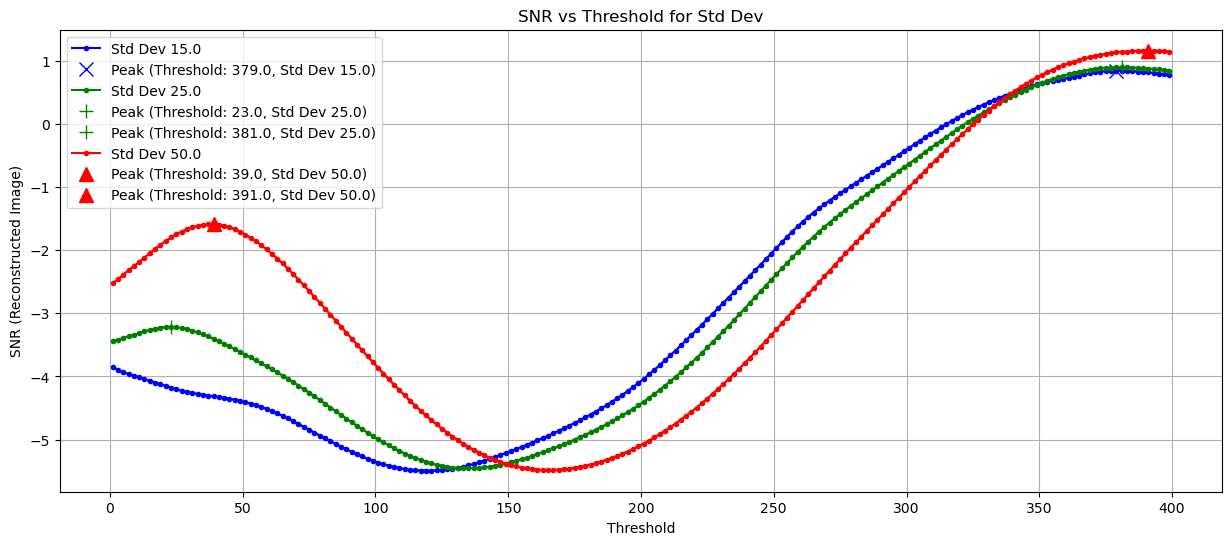

In [179]:
# Plot SNR vs Threshold for a particular std_dev
plot_snr_vs_threshold(combined_list_df)

# # Plot SNR vs AWGN Std Dev
# plot_snr_vs_std_dev(combined_results_df)
# plot_ssim_vs_snr(combined_list_df)

In [165]:
averages = combined_results_df.mean()

In [166]:
averages

Std_Dev               3.000000e+01
Threshold             2.000000e+02
MSE                   1.037711e+02
PSNR                  1.155774e+01
SSIM                  1.855934e-01
Entropy              -1.547231e+06
Standard_Deviation    5.238680e+01
Variance              2.979577e+03
SNR_Original         -3.036881e+00
SNR_Reconstructed    -2.690081e+00
dtype: float64

In [188]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt


def plot_snr_vs_threshold(df1, df2):
    plt.figure(figsize=(15, 6)) 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    peak_markers = ['x', '+', '^', 's', 'o']  # Define markers for peaks
    
    for i, (dataset, title) in enumerate(zip([df1, df2], ['Soft Thresholding', 'Hard Thresholding'])):
        plt.subplot(1, 2, i+1)  # Create a new subplot for each dataset
        for j in range(len(dataset)):
            plt.plot(dataset[j]['Threshold'], dataset[j]['SNR_Reconstructed'], marker='o', markersize=1)
            plt.plot(dataset[j]['Threshold'], dataset[j]['SNR_Reconstructed'], marker='o', markersize=3, label=f'Std Dev {dataset[j].at[0, "Std_Dev"]}', color=colors[j])

            # Find peaks in SNR values
            peaks, _ = find_peaks(dataset[j]['SNR_Reconstructed'])

            # Mark peaks on the plot
            for peak in peaks:
                threshold_value = dataset[j]['Threshold'].iloc[peak]
                ssim_value = dataset[j]['SSIM'].iloc[peak] 
                plt.plot(dataset[j]['Threshold'].iloc[peak], dataset[j]['SNR_Reconstructed'].iloc[peak], marker=peak_markers[j], markersize=15, linestyle='', color=colors[j], label=f'Peak (Threshold: {threshold_value}, Std Dev {dataset[j].at[0, "Std_Dev"]}, SSIM: {ssim_value:.4f})')

        plt.xlabel('Threshold')
        plt.ylabel('SNR (Reconstructed Image)')
        plt.title(title)  # Add title
        plt.grid(True)
        plt.legend()  # Add legend
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()



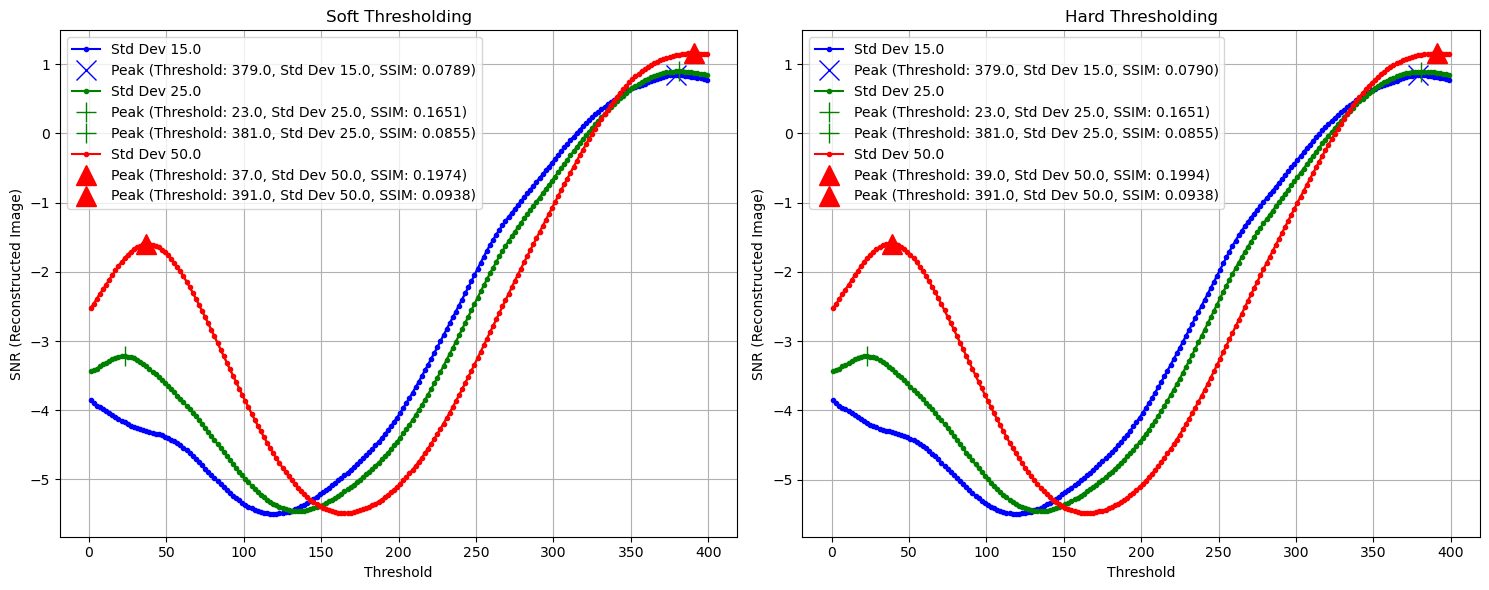

In [189]:
plot_snr_vs_threshold(combined_list_df_soft , combined_list_df)

(-0.5, 320.5, 480.5, -0.5)

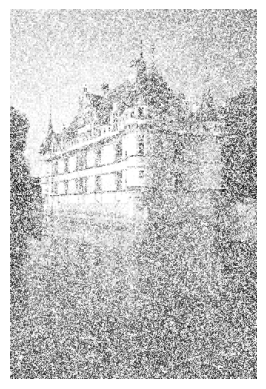

In [309]:

original_image = cv2.imread('images/test003.png', cv2.IMREAD_GRAYSCALE)

# Define parameters
wavelet = 'haar'

noisy_image = add_awgn_noise(original_image , 50)
denois_image = denoise_image(noisy_image , wavelet , 39)


plt.imshow(denois_image, cmap='gray')
plt.axis('off')
#plt.imshow(noisy_image, cmap='gray')
# std_dev = [15,25,50]
# threshold_range = np.arange(1, 400, 2)
# std_dev_range = np.array(std_dev)

# Evaluate different std_dev and threshold values
# results_df , list_df ,snr_std_avg= evaluate_awgn_std_dev(original_image, wavelet, threshold_range, std_dev_range)

